# Pregunta 2 — CSDiD (Callaway & Sant'Anna)

Estimación ATT(g,t), agregaciones y comparación con Event-Study TWFE.

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

out_dir = "../output"

In [9]:
url = "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
df = pd.read_csv(url)

# Definir año de tratamiento (group) y bandera tratado
# _nfd = 0 son nunca tratados
# g = año de primera adopción para unidades tratadas

df = df.copy()
df["group"] = df["_nfd"]
df["treated"] = (df["group"] > 0).astype(int)

print("Forma del dataset:", df.shape)
print("Años de tratamiento (group):", sorted(df["group"].unique()))
print("Rango temporal:", df["year"].min(), "-", df["year"].max())

Forma del dataset: (1617, 12)
Años de tratamiento (group): [np.float64(1969.0), np.float64(1971.0), np.float64(1973.0), np.float64(nan), np.float64(1970.0), np.float64(1972.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1980.0), np.float64(1984.0), np.float64(1985.0)]
Rango temporal: 1964 - 1996


In [10]:
def compute_att_gt(data, outcome="asmrs"):
    records = []
    treated_groups = sorted([g for g in data["group"].unique() if g > 0])
    years = sorted(data["year"].unique())

    for g in treated_groups:
        # años donde ya está tratado ese grupo
        possible_t = [t for t in years if t >= g]
        for t in possible_t:
            # año pre base t0 = g-1
            t0 = g - 1
            treated_t = data[(data["group"] == g) & (data["year"] == t)]
            treated_t0 = data[(data["group"] == g) & (data["year"] == t0)]
            if treated_t.empty or treated_t0.empty:
                continue

            # control: nunca tratados o aún no tratados en t
            control_t = data[((data["group"] == 0) | (data["group"] > t)) & (data["year"] == t)]
            control_t0 = data[((data["group"] == 0) | (data["group"] > t)) & (data["year"] == t0)]
            if control_t.empty or control_t0.empty:
                continue

            treated_delta = treated_t[outcome].mean() - treated_t0[outcome].mean()
            control_delta = control_t[outcome].mean() - control_t0[outcome].mean()
            att = treated_delta - control_delta

            records.append({
                "group": g,
                "year": t,
                "event_time": t - g,
                "att_gt": att,
                "n_treated": len(treated_t),
                "n_control": len(control_t)
            })

    return pd.DataFrame(records)

att_gt = compute_att_gt(df)
print("ATT(g,t) calculados:", att_gt.shape)
att_gt.head()

ATT(g,t) calculados: (114, 6)


,group,year,event_time,att_gt,n_treated,n_control
0,1969.0,1969,0.0,0.870862,2,34
1,1969.0,1970,1.0,-9.574588,2,32
2,1969.0,1971,2.0,-12.382787,2,25
3,1969.0,1972,3.0,-4.231936,2,22
4,1969.0,1973,4.0,4.464084,2,12


In [11]:
# Agregaciones
tt_out = os.path.join(out_dir, "salida_preg2_1.csv")
tg_out = os.path.join(out_dir, "salida_preg2_2.csv")
tp_out = os.path.join(out_dir, "salida_preg2_3.csv")
te_out = os.path.join(out_dir, "salida_preg2_4.csv")

att_by_group = att_gt.groupby("group")["att_gt"].mean().reset_index().rename(columns={"att_gt": "att_group"})
att_by_period = att_gt.groupby("year")["att_gt"].mean().reset_index().rename(columns={"att_gt": "att_period"})
att_by_event = att_gt.groupby("event_time")["att_gt"].mean().reset_index().rename(columns={"att_gt": "att_event"})

att_gt.to_csv(tt_out, index=False)
att_by_group.to_csv(tg_out, index=False)
att_by_period.to_csv(tp_out, index=False)
att_by_event.to_csv(te_out, index=False)

print("Tablas guardadas en:")
print(" -", tt_out)
print(" -", tg_out)
print(" -", tp_out)
print(" -", te_out)

att_by_event.head()

Tablas guardadas en:
 - ../output\salida_preg2_1.csv
 - ../output\salida_preg2_2.csv
 - ../output\salida_preg2_3.csv
 - ../output\salida_preg2_4.csv


,event_time,att_event
0,0.0,0.236606
1,1.0,0.361049
2,2.0,-1.598276
3,3.0,-1.197976
4,4.0,-1.997912


### Interpretación de agregaciones
- **Por grupo (ATT(g,·))**: promedio de efectos para cada cohorte g (año de adopción). Mide heterogeneidad entre cohortes.
- **Por período (ATT(·,t))**: promedio entre cohortes activas en año t. Captura shocks temporales del tratamiento.
- **Por tiempo relativo (ATT(e))**: promedio por distancia al tratamiento (event_time = t−g). Es lo más comparable con los coeficientes del Event-Study TWFE.

In [12]:
# Comparación CSDiD (event_time) vs Event-Study TWFE
es_path = os.path.join(out_dir, "salida_2.csv")
if os.path.exists(es_path):
    es_twfe = pd.read_csv(es_path)
    es_twfe = es_twfe.rename(columns={
        "coefficient": "twfe_coef",
        "std_error": "twfe_se",
        "ci_lower": "twfe_ci_lower",
        "ci_upper": "twfe_ci_upper"
    })
else:
    es_twfe = pd.DataFrame()
    print("ADVERTENCIA: No se encontró salida_2.csv; omitiendo comparación.")

comparison = att_by_event.merge(es_twfe, on="event_time", how="outer", indicator=True)
comp_out = os.path.join(out_dir, "salida_preg2_5.csv")
comparison.to_csv(comp_out, index=False)
print("Tabla comparación guardada en", comp_out)
comparison.head()

Tabla comparación guardada en ../output\salida_preg2_5.csv


,event_time,att_event,twfe_coef,twfe_se,twfe_ci_lower,twfe_ci_upper,t_stat,p_value,_merge
0,-10.0,NaN,-2.758690,3.942956,-10.486885,4.969504,-0.699650,0.484146,right_only
1,-9.0,NaN,-4.782526,3.711926,-12.057901,2.492849,-1.288422,0.197599,right_only
2,-8.0,NaN,-2.809514,3.930921,-10.514118,4.895091,-0.714722,0.474781,right_only
3,-7.0,NaN,-1.160466,4.421886,-9.827363,7.506431,-0.262437,0.792985,right_only
4,-6.0,NaN,-0.786246,2.983483,-6.633874,5.061381,-0.263533,0.792140,right_only


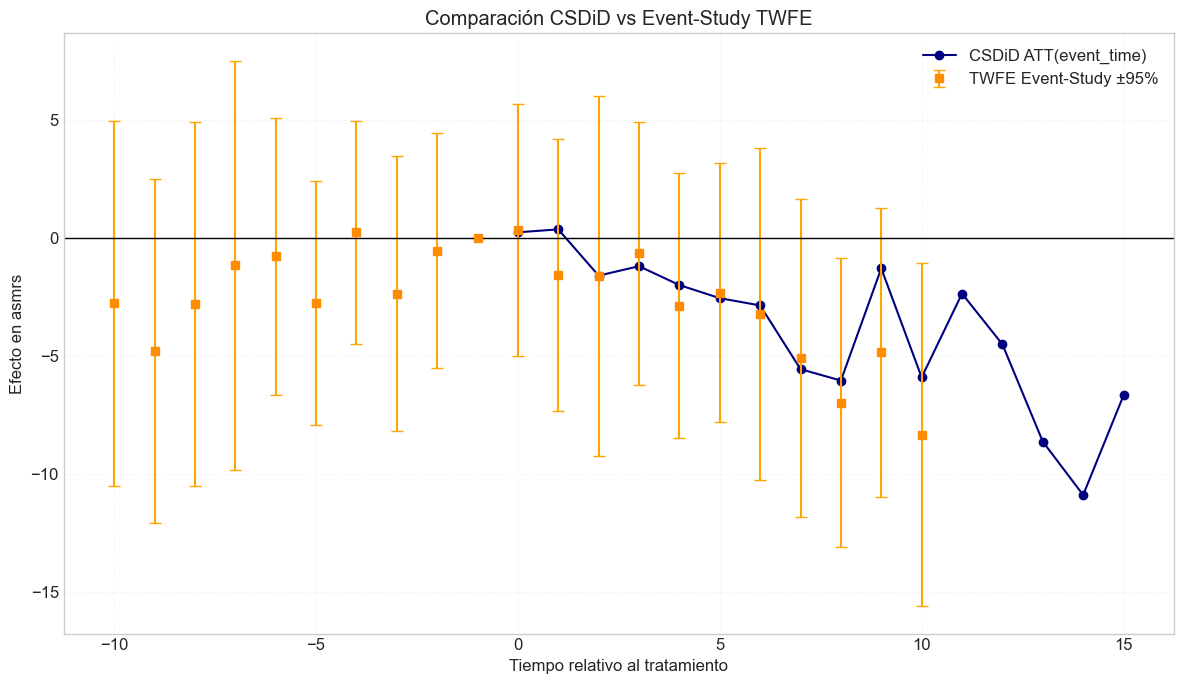

Gráfico guardado en ../output\salida_preg2_6.png


In [13]:
# Gráfico combinado (si existe TWFE)
if not es_twfe.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(att_by_event['event_time'], att_by_event['att_event'], 'o-', label='CSDiD ATT(event_time)', color='navy')

    ax.errorbar(es_twfe['event_time'], es_twfe['twfe_coef'],
                yerr=1.96 * es_twfe['twfe_se'], fmt='s', color='darkorange',
                ecolor='orange', capsize=4, label='TWFE Event-Study ±95%')

    ax.axhline(0, color='black', linewidth=1)
    ax.set_xlabel('Tiempo relativo al tratamiento')
    ax.set_ylabel('Efecto en asmrs')
    ax.set_title('Comparación CSDiD vs Event-Study TWFE')
    ax.legend()
    ax.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    plot_out = os.path.join(out_dir, 'salida_preg2_6.png')
    plt.savefig(plot_out, dpi=300, bbox_inches='tight')
    plt.show()
    print("Gráfico guardado en", plot_out)
else:
    print("No se generó gráfico combinado porque no se encontró salida_2.csv")

### Discusión breve
- ATT(event_time) de CSDiD usa como control los no tratados o aún no tratados → evita comparaciones prohibidas.
- TWFE Event-Study puede tener pesos negativos; contraste de ambos muestra si TWFE sesga.
- Agregación por tiempo relativo es la comparable con los coeficientes del Event-Study.